In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F
import re
from  pathlib import Path

In [2]:
import re
import pandas as pd


def read_whatsapp_chat(file_path: str) -> pd.DataFrame:
    # Define filtering patterns
    encryption_message = "Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more."
    media_pattern = "<Media omitted>"
    email_pattern = r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    edited_message = "<This message was edited>"
    deleted_message = "You deleted this message"
    null_message = "null"
    created_group_message = "created group"
    added_you_to_group_message = "added you"
    tagging_pattern = r'@[\w]+'

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Apply filters to remove unwanted lines
    filtered_lines = []
    for line in lines:
        if (
            encryption_message not in line and
            deleted_message not in line and
            null_message != line.split(" ")[-1] and
            media_pattern not in line and
            created_group_message not in line and
            added_you_to_group_message not in line and
            not re.search(email_pattern, line) and
            not re.search(url_pattern, line)
        ):
            line = line.replace(edited_message, "").strip()
            line = re.sub(tagging_pattern, "", line).strip()
            filtered_lines.append(line)

    # Normalize content:
    content = '\n'.join(filtered_lines)
    # Replace narrow no-break space (iOS specific)
    content = content.replace('\u202f', ' ')
    # Remove square brackets if they surround the timestamp (only for iOS)
    content = re.sub(
        r'\[(\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}(?::\d{2})?\s?[APap][Mm])\]',
        r'\1',
        content
    )
    # Remove LRM and RLM characters (Left-to-Right Mark and Right-to-Left Mark)
    content = content.replace('\u200E', '').replace('\u200F', '')

    # Updated regex pattern to match both iOS and Android WhatsApp exports.
    pattern = r'(\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}(?::\d{2})?(?:\s?[APap][Mm])?)\s?(?:-|\~)?\s?(.*?): (.*?)(?=\n\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}|$)'
    messages = re.findall(pattern, content, re.DOTALL)
    df = pd.DataFrame(messages, columns=['timestamp', 'sender', 'message'])

    timestamps = []
    for timestamp in df['timestamp']:
        try:
            timestamp = pd.to_datetime(
                timestamp, format='mixed', errors='coerce')
        except Exception as e:
            print(f"Error parsing timestamp '{timestamp}': {e}")
            timestamp = pd.NaT
        timestamps.append(timestamp)

    df['timestamp'] = timestamps
    return df

In [3]:
all_chats={}
data_path=Path("Data\private")
for file in data_path.glob("*.txt"):
    chat_name=file.stem
    all_chats[chat_name]=read_whatsapp_chat(file)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\shree\AppData\Local\Temp\ipykernel_41704\1343640759.py:2: SyntaxWarning: invalid escape sequence '\p'
  data_path=Path("Data\private")


In [4]:
text_seq=""
for file_name in all_chats.keys():
    text_seq+=''.join(all_chats[file_name]['message'].values)

print(f"Length of text: {len(text_seq)} characters")

Length of text: 349552 characters


In [5]:
with open("outputs/combined_text.txt", "w", encoding="utf-8") as f:
    f.write(text_seq)

In [6]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input='outputs\combined_text.txt',
    model_prefix='spm_model',
    vocab_size=5762,
    model_type='unigram',   # or 'bpe', 'word'
    character_coverage=0.9995,
    pad_id=0, unk_id=1, bos_id=2, eos_id=3,
    user_defined_symbols='[MASK]'
)
# This writes spm_model.model and spm_model.vocab


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\shree\AppData\Local\Temp\ipykernel_41704\3702855359.py:4: SyntaxWarning: invalid escape sequence '\c'
  input='outputs\combined_text.txt',


In [7]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load("spm_model.model")

# Encode text into IDs
ids = sp.encode("My name is Shree")
print(ids)   

# Decode IDs back into text
text = sp.decode(ids)
print(text)  


[199, 51, 441, 22, 218]
My name is Shree


In [8]:
from typing import Optional
import math
import torch
import torch.nn as nn
import torch.nn.functional as F



dim: int = 512
n_layers: int = 8
n_heads: int = 8
vocab_size: int = 5762
ffn_dim_multiplier: 4
norm_eps: float = 1e-5
dropout=0.2
# Needed for KV cache
max_batch_size: int = 32
context_length: int = 256

device= 'cuda' if torch.cuda.is_available()  else 'cpu'
device

'cuda'

In [9]:
import torch
import torch.nn as nn
import math

# Set device and context_length
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
context_length = 256
vocab_size = 5762

class InputEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEmbedding(nn.Module):
    def __init__(self, sequence_length: int, d_model: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(sequence_length, d_model)
        pos = torch.arange(0, sequence_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)

        # Register as buffer so it moves with .to(device)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1], :].requires_grad_(False)
        return self.dropout(x)

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        output = self._norm(x.float())
        # self.weight will be on the same device as x after model.to(device)
        return self.weight * output.type_as(x)

class FeedForward(nn.Module):
    def __init__(self, d_model: int, dropout: float, ff=4):
        super().__init__()
        self.d_model = d_model
        self.ffw = nn.Sequential(
            nn.Linear(d_model, ff * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff * d_model, d_model),
        )
    
    def forward(self, x):
        return self.ffw(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float, context_length: int):
        super().__init__()
        self.d_model = d_model
        self.h = n_head
        assert d_model % n_head == 0, 'd_model is not divisible by the no. of heads'
        
        self.dk = d_model // self.h
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # Register as buffer so it moves with .to(device)
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        dk = query.shape[-1]
        attention_scores = (query @ key.transpose(-1, -2)) / math.sqrt(dk)
        
        T = query.shape[-2]
        attention_scores = attention_scores.masked_fill(mask[:T, :T] == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v):
        key = self.w_k(k)
        query = self.w_q(q)
        value = self.w_v(v)

        query = query.view(query.shape[0], query.shape[1], self.h, self.dk).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.dk).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.dk).transpose(1, 2)

        x, self.attention_scores = self.attention(query, key, value, self.tril, self.dropout)

        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.dk)
        return self.w_o(x)

class ResidualConnection(nn.Module):
    def __init__(self, dropout: float, d_model: int):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = RMSNorm(d_model)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class DecoderBlock(nn.Module):
    def __init__(self, cross_multihead_attention: MultiHeadAttention, 
                 feed_forward: FeedForward, dropout: float, d_model: int):
        super().__init__()
        self.cross_multihead_attention = cross_multihead_attention
        self.feed_forward = feed_forward
        self.dropout = dropout
        # Only 2 residual connections in a decoder-only block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout, d_model) for _ in range(2)]) 

    def forward(self, x):
        x = self.residual_connections[0](x, lambda x: self.cross_multihead_attention(x, x, x))
        x = self.residual_connections[1](x, self.feed_forward)
        return x

class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList, d_model: int):
        super().__init__()
        self.layers = layers
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.proj = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)

class Transformer(nn.Module):
    def __init__(self, vocab_size: int, seq_length: int,
                 d_model=512, n_layers=6, n_heads=8, dropout=0.2):
        super().__init__()
        self.token_embd = InputEmbedding(vocab_size, d_model)
        self.pos_emd = PositionalEmbedding(seq_length, d_model, dropout)
        
        decoder_blocks = []
        for _ in range(n_layers):
            decoder_cross_attention = MultiHeadAttention(d_model, n_heads, dropout, seq_length)
            ffw = FeedForward(d_model, dropout)
            decoder_block = DecoderBlock(decoder_cross_attention, ffw, dropout, d_model)
            decoder_blocks.append(decoder_block)
        
        self.decoder = Decoder(nn.ModuleList(decoder_blocks), d_model)
        self.rms = RMSNorm(d_model)
        self.proj_layer = ProjectionLayer(d_model, vocab_size)


    def _init_weights(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_tokens,targets: Optional[torch.Tensor] = None):
        B, T = input_tokens.shape
        t_emb = self.token_embd(input_tokens)
        x = self.pos_emd(t_emb)
        x = self.decoder(x)
        x = self.rms(x)
        logits = self.proj_layer(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits,loss
    


    def generate(self, input_tokens: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """
                Generate new tokens given a context.

                Args:
                        input_tokens: Starting token indices of shape (batch_size, sequence_length)
                        max_new_tokens: Number of new tokens to generate

                Returns:
                        Tensor of token indices of shape (batch_size, sequence_length + max_new_tokens)
                """

        # input_tokens is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop input_tokens to the last block_size tokens
            cropped_input = input_tokens[:, -context_length:]
            # get the predictions
            logits, _ = self(cropped_input)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            input_tokens = torch.cat(
                (input_tokens, idx_next), dim=1)  # (B, T+1)
        return input_tokens
    



In [10]:
transformer = Transformer(vocab_size=vocab_size, seq_length=context_length,
                        d_model=512, n_layers=6, n_heads=8, dropout=0.2)

# Move model to device
model = transformer.to(device)
# Create input and move to device
x= torch.randint(0, vocab_size, (1, context_length)).to(device)

# Forward pass
output,_ = model(x)
print(f"Output shape: {output.shape}")
print(f"Device: {output.device}")

Output shape: torch.Size([1, 256, 5762])
Device: cuda:0


In [11]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M para')

24.803458 M para


In [12]:
with open('outputs\combined_text.txt','r') as f:
    text_sequence=f.read()

encoded_text_sequence=sp.Encode(text_sequence)
len(encoded_text_sequence)

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\shree\AppData\Local\Temp\ipykernel_41704\1466599194.py:1: SyntaxWarning: invalid escape sequence '\c'
  with open('outputs\combined_text.txt','r') as f:


110189

In [13]:
data=torch.tensor(encoded_text_sequence,dtype=torch.long)
split_index=int(0.95*len(data))
train_data=data[:split_index]
test_data=data[split_index:]

In [14]:
from typing import Tuple


def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else test_data
    index = torch.randint(len(data) - context_length, (context_length,))
    x = torch.stack([data[i:i+context_length] for i in index])
    y = torch.stack([data[i+1:i+context_length+1] for i in index])
    x, y = x.to(device), y.to(device)
    return x, y

x, y = get_batch('train')
x.shape, y.shape

(torch.Size([256, 256]), torch.Size([256, 256]))

In [15]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        if len(data) <= block_size:
            raise ValueError(
                f"The length of the data ({len(data)}) must be greater than the block_size ({block_size})."
            )

        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index : index + self.block_size]
        y = self.data[index + 1 : index + self.block_size + 1]
        return x, y


def get_dataloaders(
    train_data: torch.Tensor,
    val_data: torch.Tensor,
    block_size: int,
    batch_size: int,
    device: torch.device,
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [16]:
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=test_data,
    block_size=context_length,
    batch_size=64,
    device=device,
)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

In [17]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _,loss= model(x,y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [18]:
def save_checkpoint(
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [19]:
from tqdm import tqdm

In [ ]:
epochs = 2
eval_interval = 100
eval_iters = 200
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {epoch} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch==1:
        # Save checkpoint
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            loss=loss.item(),
            file_path=f"outputs/pre_training/run_4/checkpoint_{epoch}.pth"
        )

  0%|          | 0/2 [00:00<?, ?it/s]

iteration 0 / step 0: train loss 0.0520, val loss 14.3975
iteration 0 / step 100: train loss 0.0533, val loss 14.4768
iteration 0 / step 200: train loss 0.0527, val loss 14.4306
iteration 0 / step 300: train loss 0.0507, val loss 14.5233
iteration 0 / step 400: train loss 0.0500, val loss 14.5608
iteration 0 / step 500: train loss 0.0510, val loss 14.4755
iteration 0 / step 600: train loss 0.0524, val loss 14.5216
iteration 0 / step 700: train loss 0.0502, val loss 14.5631
iteration 0 / step 800: train loss 0.0507, val loss 14.5208
iteration 0 / step 900: train loss 0.0516, val loss 14.6094
iteration 0 / step 1000: train loss 0.0502, val loss 14.5357
iteration 0 / step 1100: train loss 0.0487, val loss 14.5504
iteration 0 / step 1200: train loss 0.0488, val loss 14.6517
iteration 0 / step 1300: train loss 0.0490, val loss 14.7099
iteration 0 / step 1400: train loss 0.0492, val loss 14.6438
iteration 0 / step 1500: train loss 0.0481, val loss 14.5984
iteration 0 / step 1600: train loss 

 50%|█████     | 1/2 [32:41<32:41, 1961.43s/it]

iteration 1 / step 0: train loss 0.0479, val loss 14.6487
iteration 1 / step 100: train loss 0.0478, val loss 14.7414
iteration 1 / step 200: train loss 0.0478, val loss 14.7954
iteration 1 / step 300: train loss 0.0481, val loss 14.7632
iteration 1 / step 400: train loss 0.0480, val loss 14.7619
iteration 1 / step 500: train loss 0.0466, val loss 14.7792
iteration 1 / step 600: train loss 0.0473, val loss 14.7389
iteration 1 / step 700: train loss 0.0468, val loss 14.7211
iteration 1 / step 800: train loss 0.0474, val loss 14.8516
iteration 1 / step 900: train loss 0.0460, val loss 14.8870
iteration 1 / step 1000: train loss 0.0475, val loss 14.9961
iteration 1 / step 1100: train loss 0.0451, val loss 14.9714
iteration 1 / step 1200: train loss 0.0447, val loss 14.9392
iteration 1 / step 1300: train loss 0.0461, val loss 14.9477
iteration 1 / step 1400: train loss 0.0454, val loss 14.9138
iteration 1 / step 1500: train loss 0.0455, val loss 14.8850
iteration 1 / step 1600: train loss 

 50%|█████     | 1/2 [1:05:27<1:05:27, 3927.87s/it]


RuntimeError: Parent directory ../output/pre_training/run_4 does not exist.

In [210]:
# Save checkpoint
save_checkpoint(
    model=model,
    optimizer=optimizer,
    epoch=epoch,
    loss=loss.item(),
    file_path=f"C:/Users/shree/OneDrive/Documents/Trasnformer_architecture/outputs/checkpoint_{epoch}.pth"
)

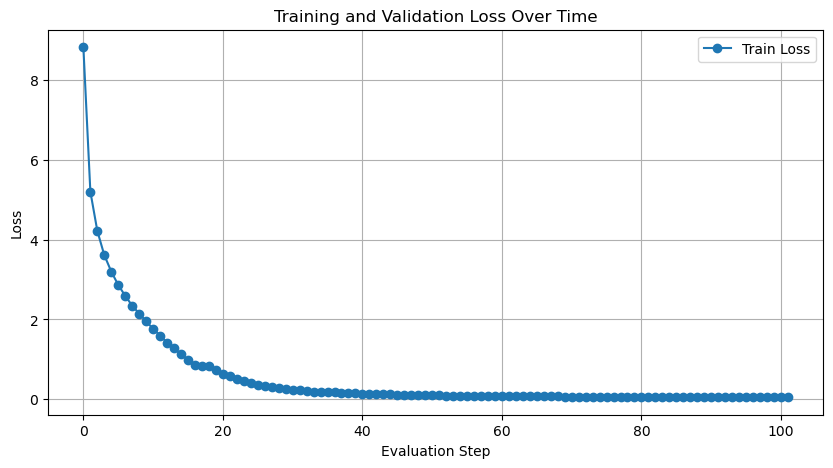

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
# plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [553]:
input_tokens = sp.Encode("clg hain?")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=1)

print(sp.Decode(output[0].tolist()))

clg hain?Haan


In [554]:
input_tokens = sp.Encode("postal code mumbai")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=1)

print(sp.Decode(output[0].tolist()))

postal code mumbai 400088


In [560]:
input_tokens = sp.Encode("paper")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=9)

print(sp.Decode(output[0].tolist()))

paper ka working part karna hai tohI hav


In [565]:
input_tokens = sp.Encode("araha hain?")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=10)

print(sp.Decode(output[0].tolist()))

araha hain?nahiOm bhai bohot traffic hain and train bhi


In [569]:
input_tokens = sp.Encode("in hain kya?")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=1)

print(sp.Decode(output[0].tolist()))

in hain kya?Haan


In [572]:
input_tokens = sp.Encode("code")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=50)

print(sp.Decode(output[0].tolist()))

code💀Let's try 🫡😂Bruh imma tryAlso if ur doing local pc pe then use torch.amppehle ye run karta hu kal shaam ko30 percent reduction guaranteedHaan
